# Benchmarking Twin Primes Generation Programs
In this notebook, we will benchmark the twin prime generation programs and see 
how using **MPI**, we can improve the run-time.

In [14]:
import subprocess
import numpy as np
import pandas as pd
import matplotlib
from   matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
from copy import deepcopy

In [2]:
# Setup for plotting

sns.set(style='darkgrid')
matplotlib.rcParams['figure.dpi'] = 300
matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['figure.figsize'] = (16, 5)

In [3]:
# Building repository
 
!make

gcc -g -Wall -c serial.c -o serial.o
gcc -g -Wall serial.o -o serial
mpicxx -g -Wall -c parallel.c -o parallel.o
mpicxx -g -Wall parallel.o -o parallel


In [4]:
# Hyper-parameters as specified in the problem statment

N_PROCESS = [1, 2, 4, 8]            # Number of processes running
M = [4, 6, 8, 10]                   # The value of `m`
K = [10 ** i for i in range(2, 9)]  # The last of value of `k`

In [6]:
outputs = list()

# Run the serial program for different `m` and last `k`
for m in M:
    for k in K:
        for it in tqdm(range(5), desc=f'm = {m:2}, k = {k:9}'):
            output_string = subprocess.run(f'./serial {m} {k}', 
                                           capture_output=True,
                                           shell=True).stdout.decode('utf-8')
            outputs.append(output_string)

m = 10, k = 100000000: 100%|██████████| 5/5 [03:07<00:00, 37.54s/it]


In [7]:
# Run the MPI program for different `np`, `m` and last `k`

for np in N_PROCESS[1:]:
    for m in M:
        for k in K:
            for it in tqdm(range(5), desc=f'np = {np}, m = {m:2}, k = {k:9}'):
                output_string = subprocess.run(f'mpirun -np {np} parallel {m} {k}', 
                                            capture_output=True,
                                            shell=True).stdout.decode('utf-8')
                outputs.append(output_string)

np = 8, m = 10, k = 100000000: 100%|██████████| 5/5 [00:30<00:00,  6.15s/it]


In [11]:
# Parse the outputs to get number of twin primes and elapsed time

def parse(output_string):
    """Parse output string to extract number of twin primes and execution time
    :param output_string: output string 
    :type output_string: str
    """
    words = output_string[5:].split('ms')[0].strip().split()
    n_twin_primes = int(words[0])
    elapsed_time  = float(words[-1])
    return n_twin_primes, elapsed_time

data = {k : {'m': [], 'time': [], 'environment': [], 'primes': [] } for k in K}

i = 0

for np in N_PROCESS:
    for m in M:
        for k in K:
            for it in range(5):
                n_twin_primes, elapsed_time = parse(outputs[i])
                data[k]['m'].append(m)
                data[k]['time'].append(elapsed_time)
                data[k]['primes'].append(n_twin_primes)
                if np == 1:
                    data[k]['environment'].append('serial')
                else:
                    data[k]['environment'].append(f'mpi-{np}')
                i += 1

In [12]:
# Check that for same `m` and `k`, no. of twin primes found are same across 
# different processes

dump = set()

for k in K:
    for m, n_tp in zip(data[k]['m'], data[k]['primes']):
        dump.add((m, k, n_tp))

assert(len(dump) == len(M) * len(K))

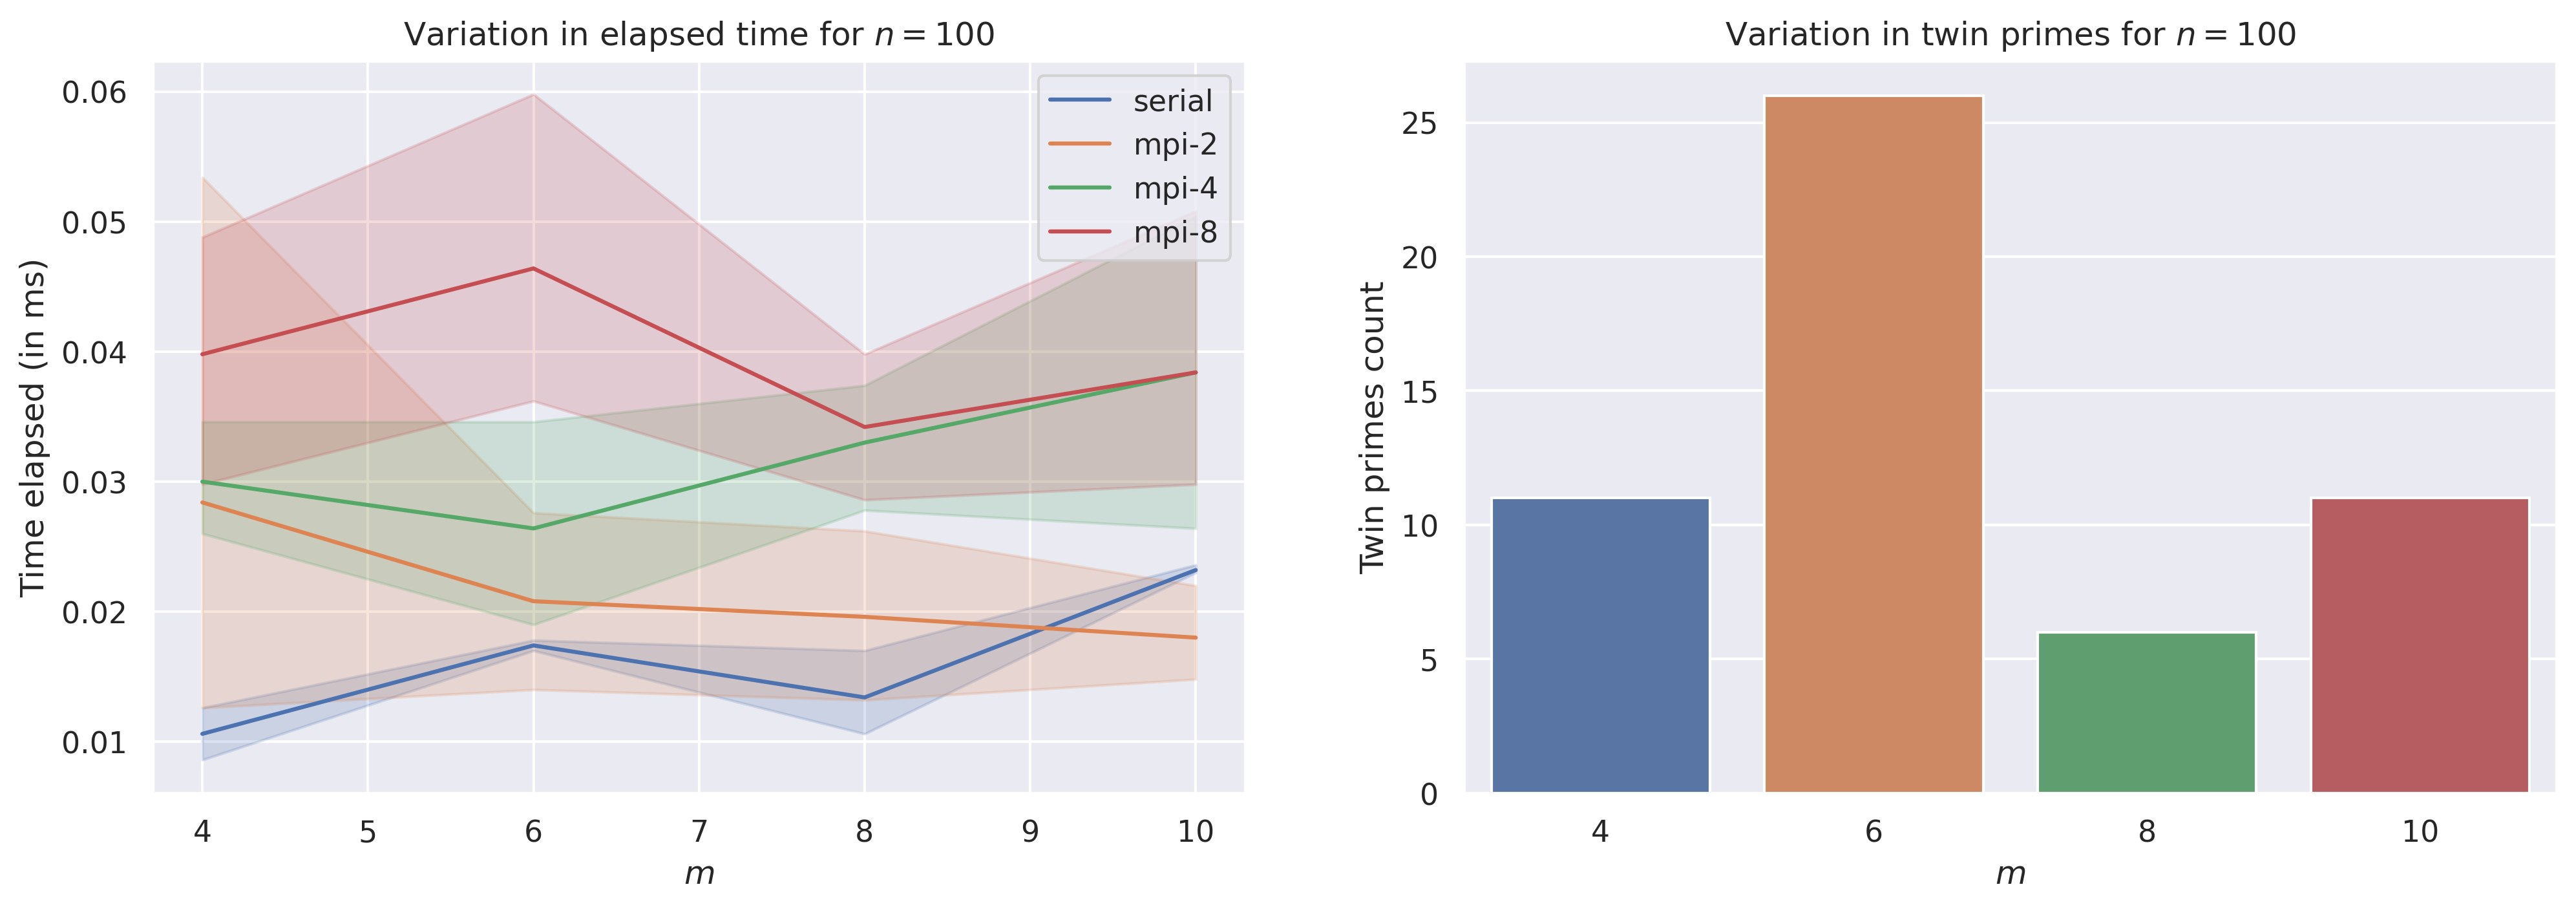

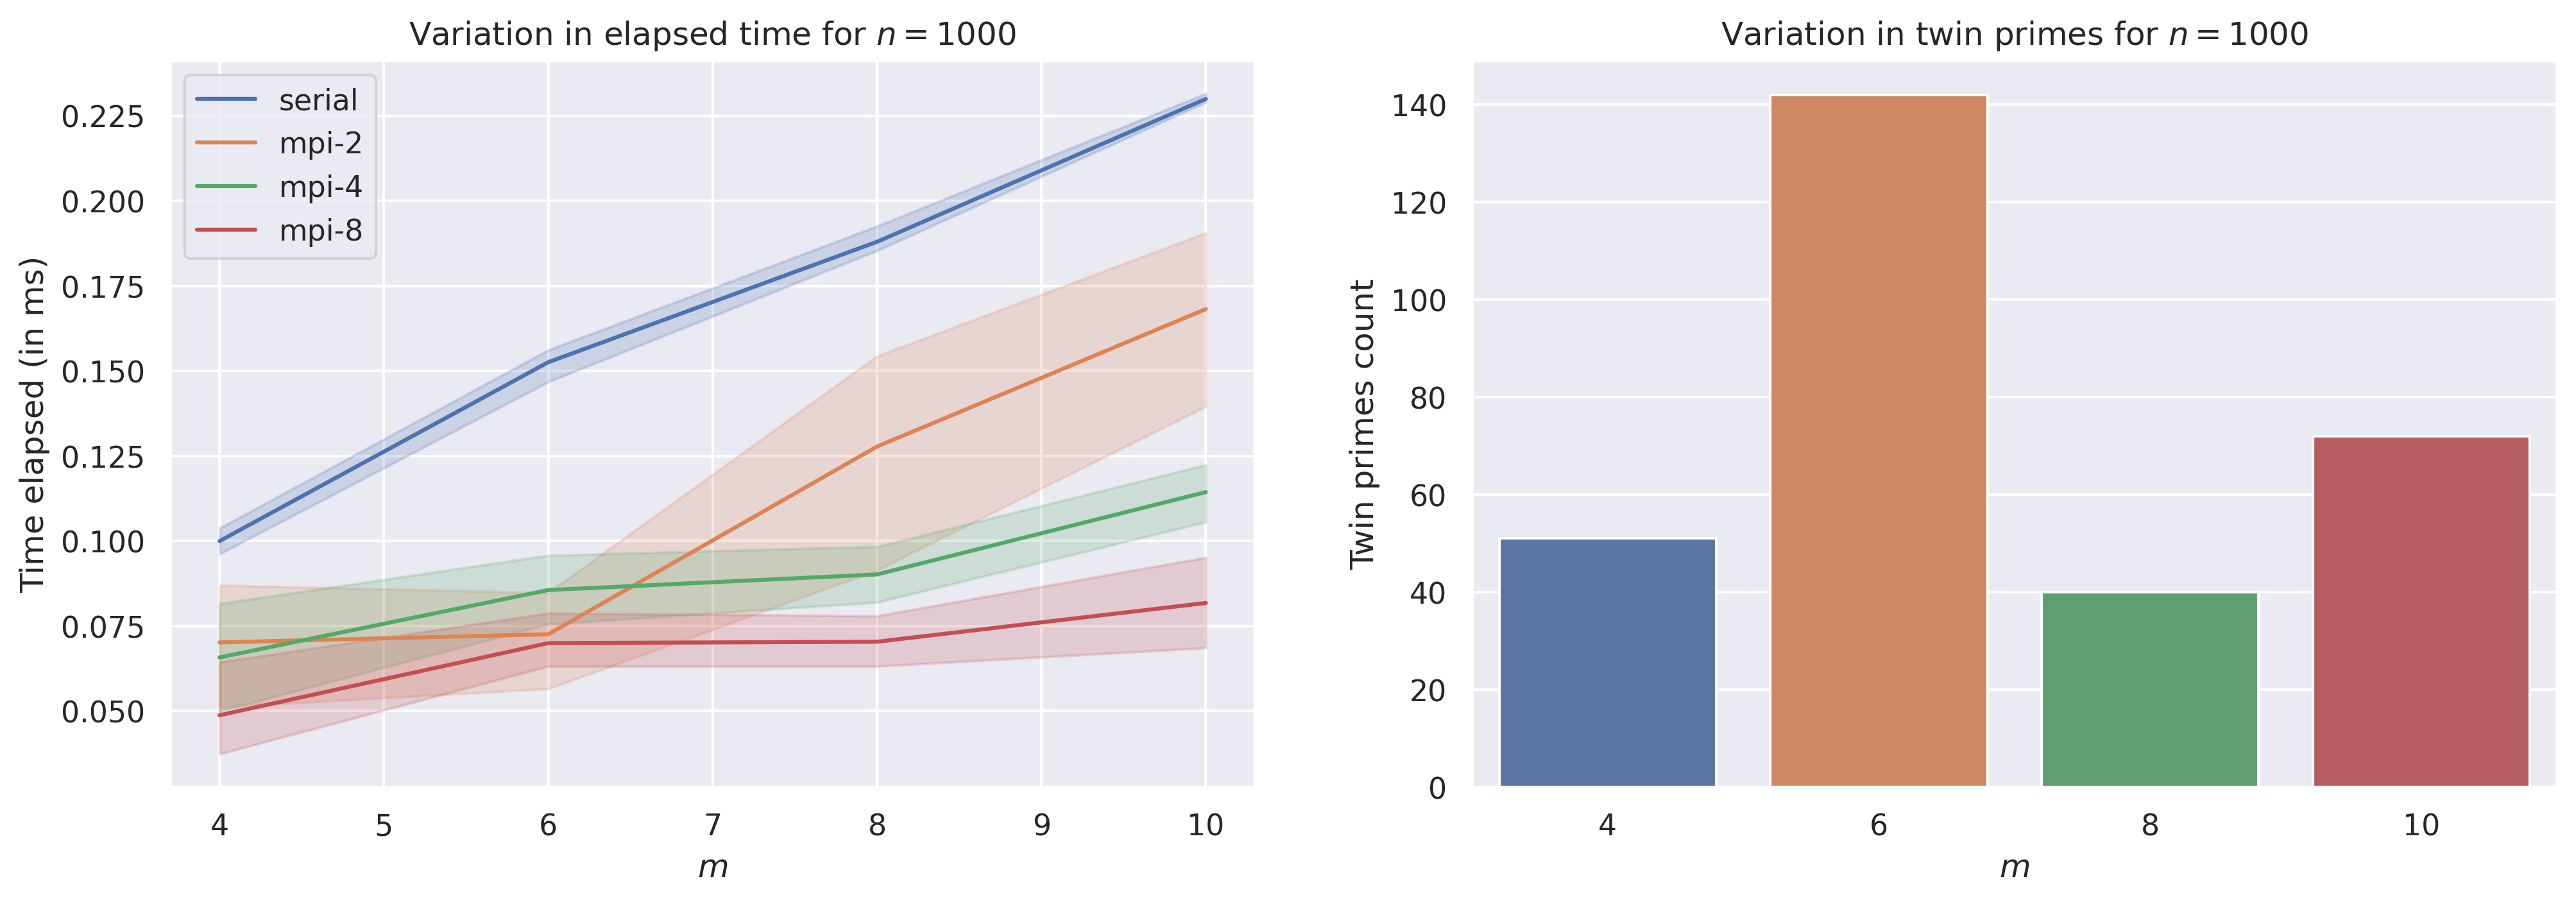

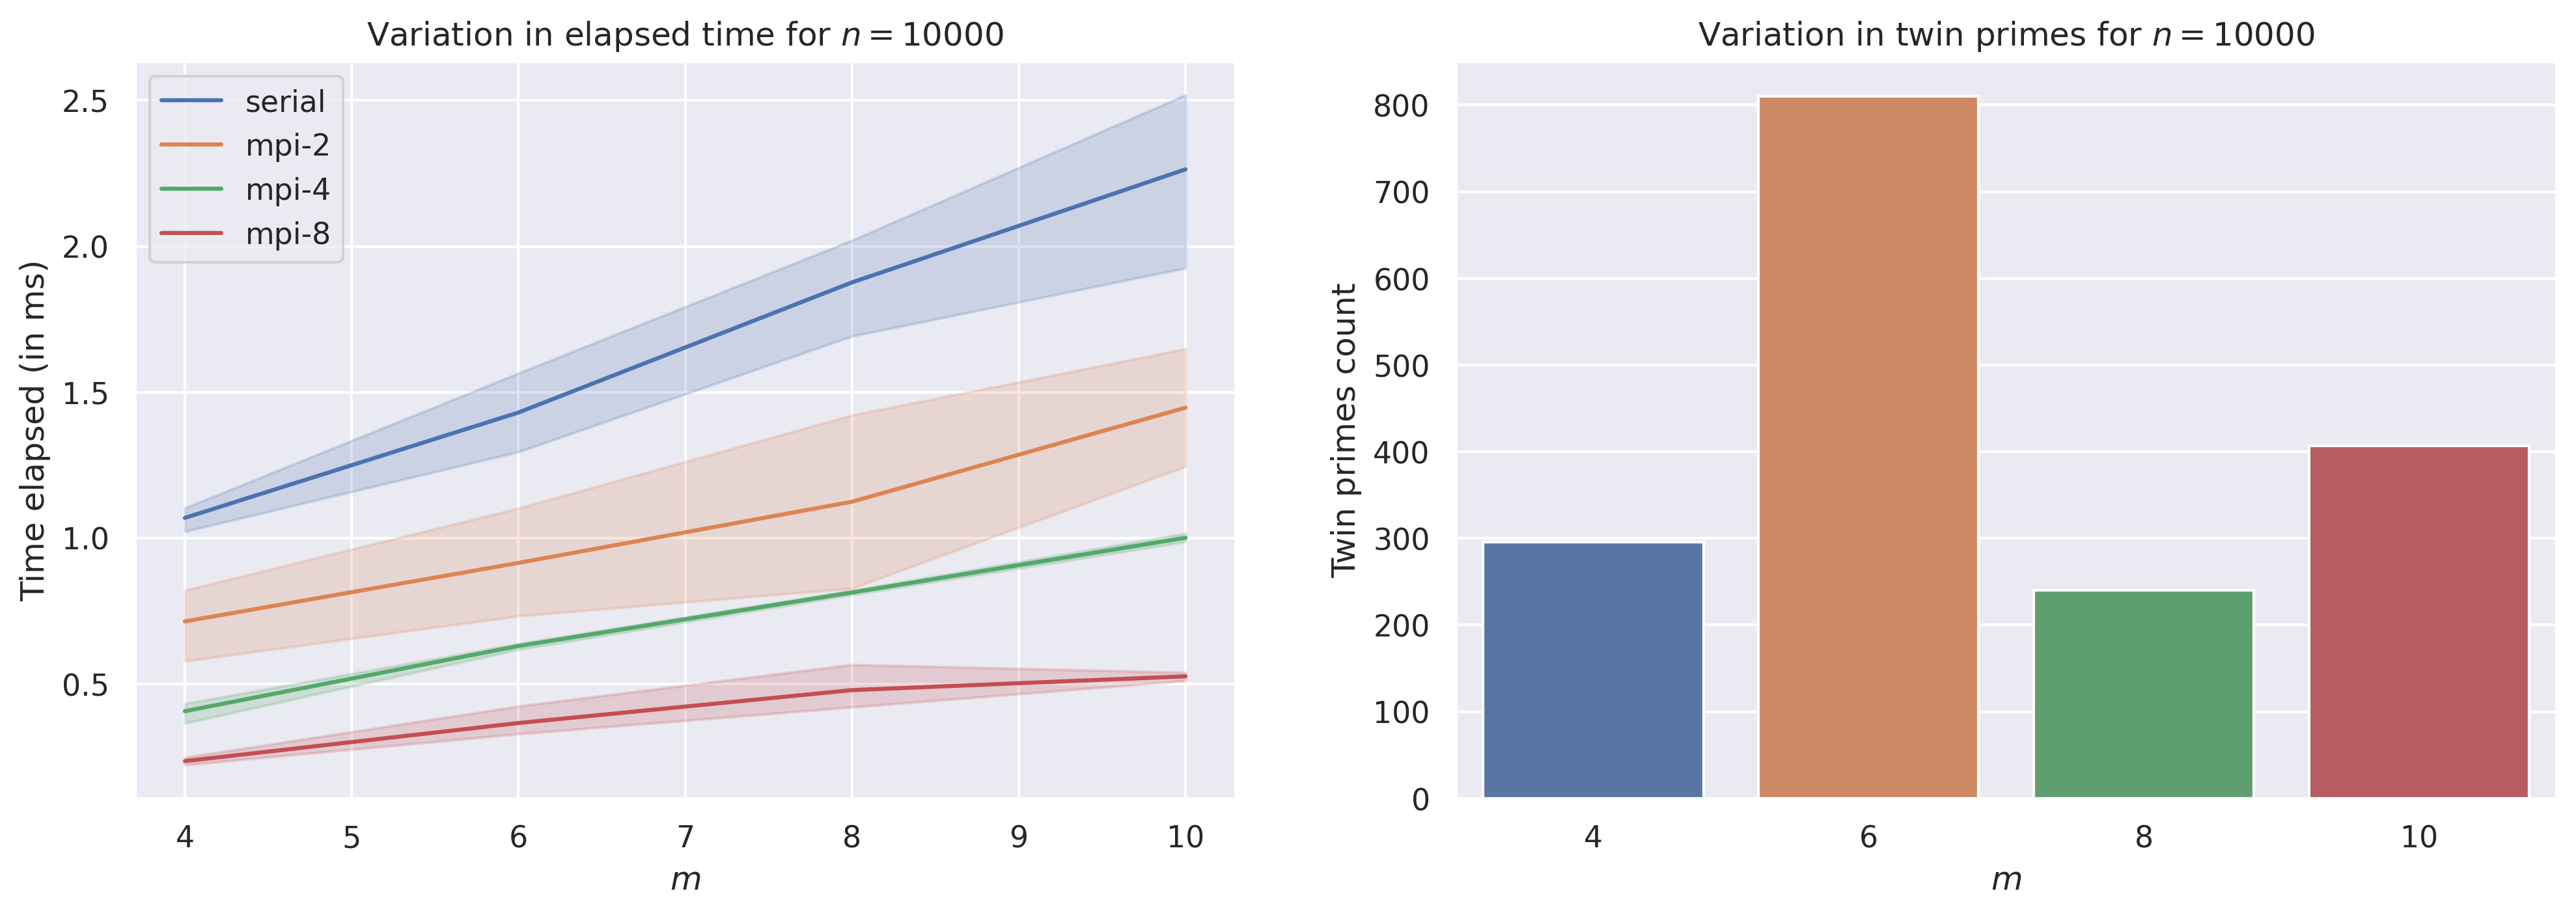

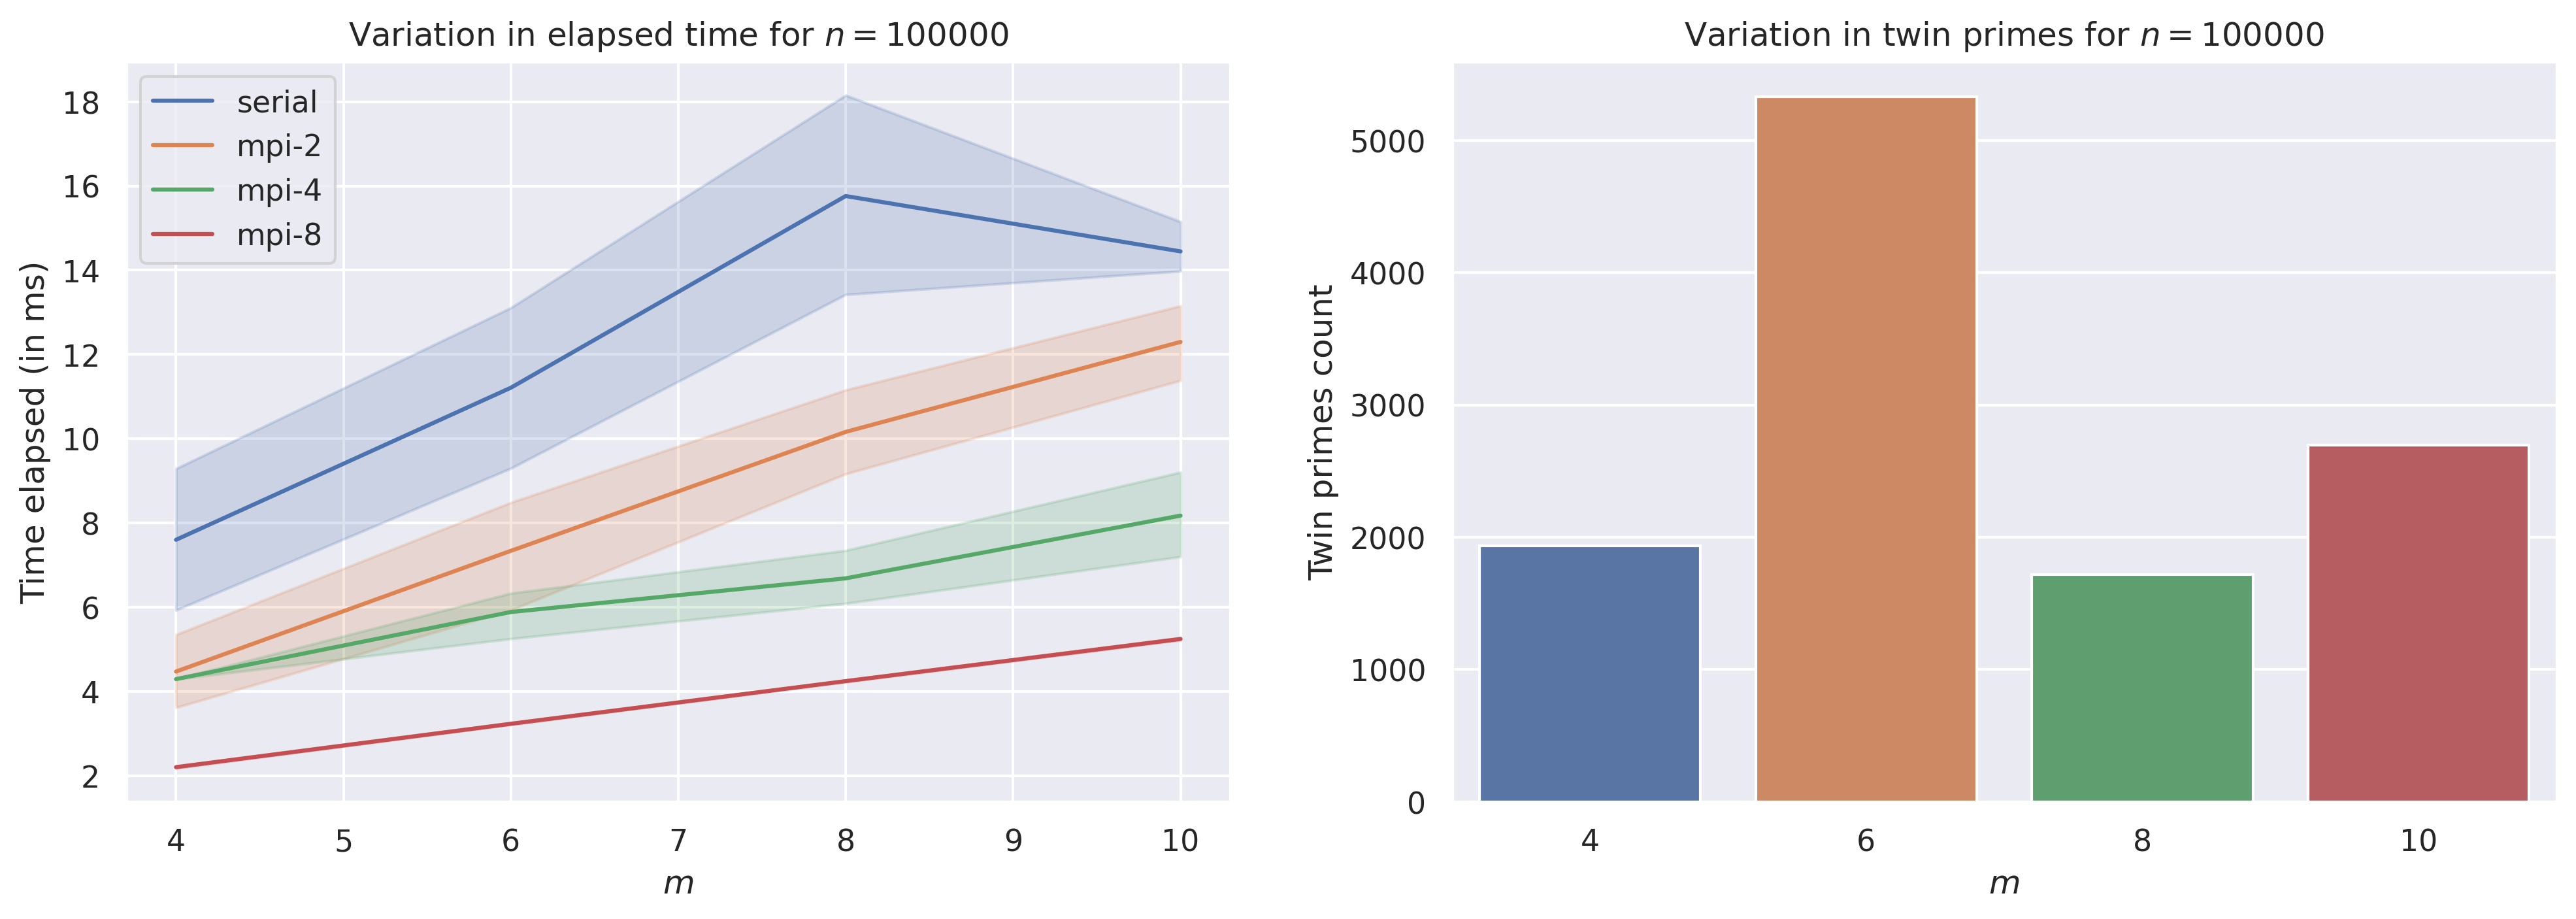

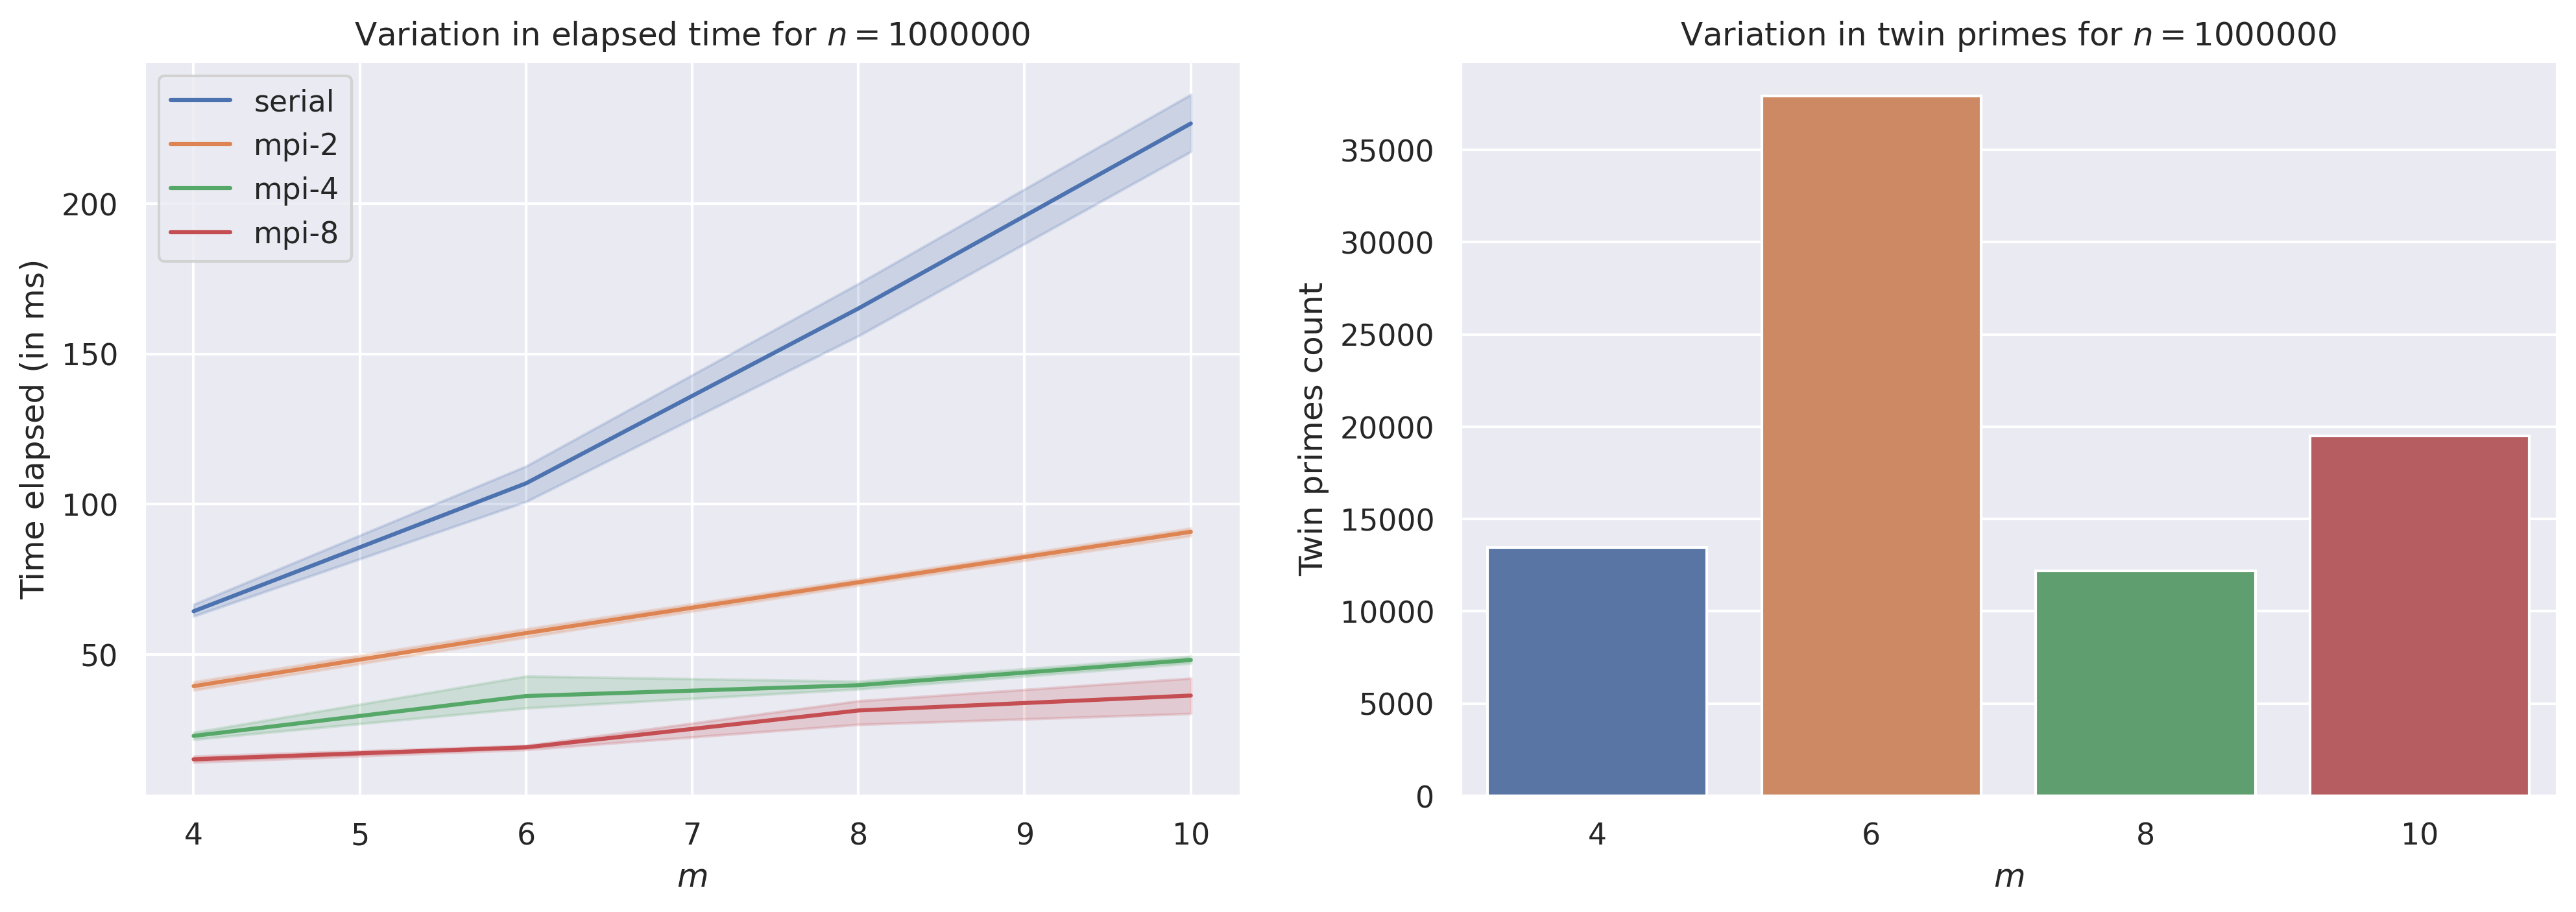

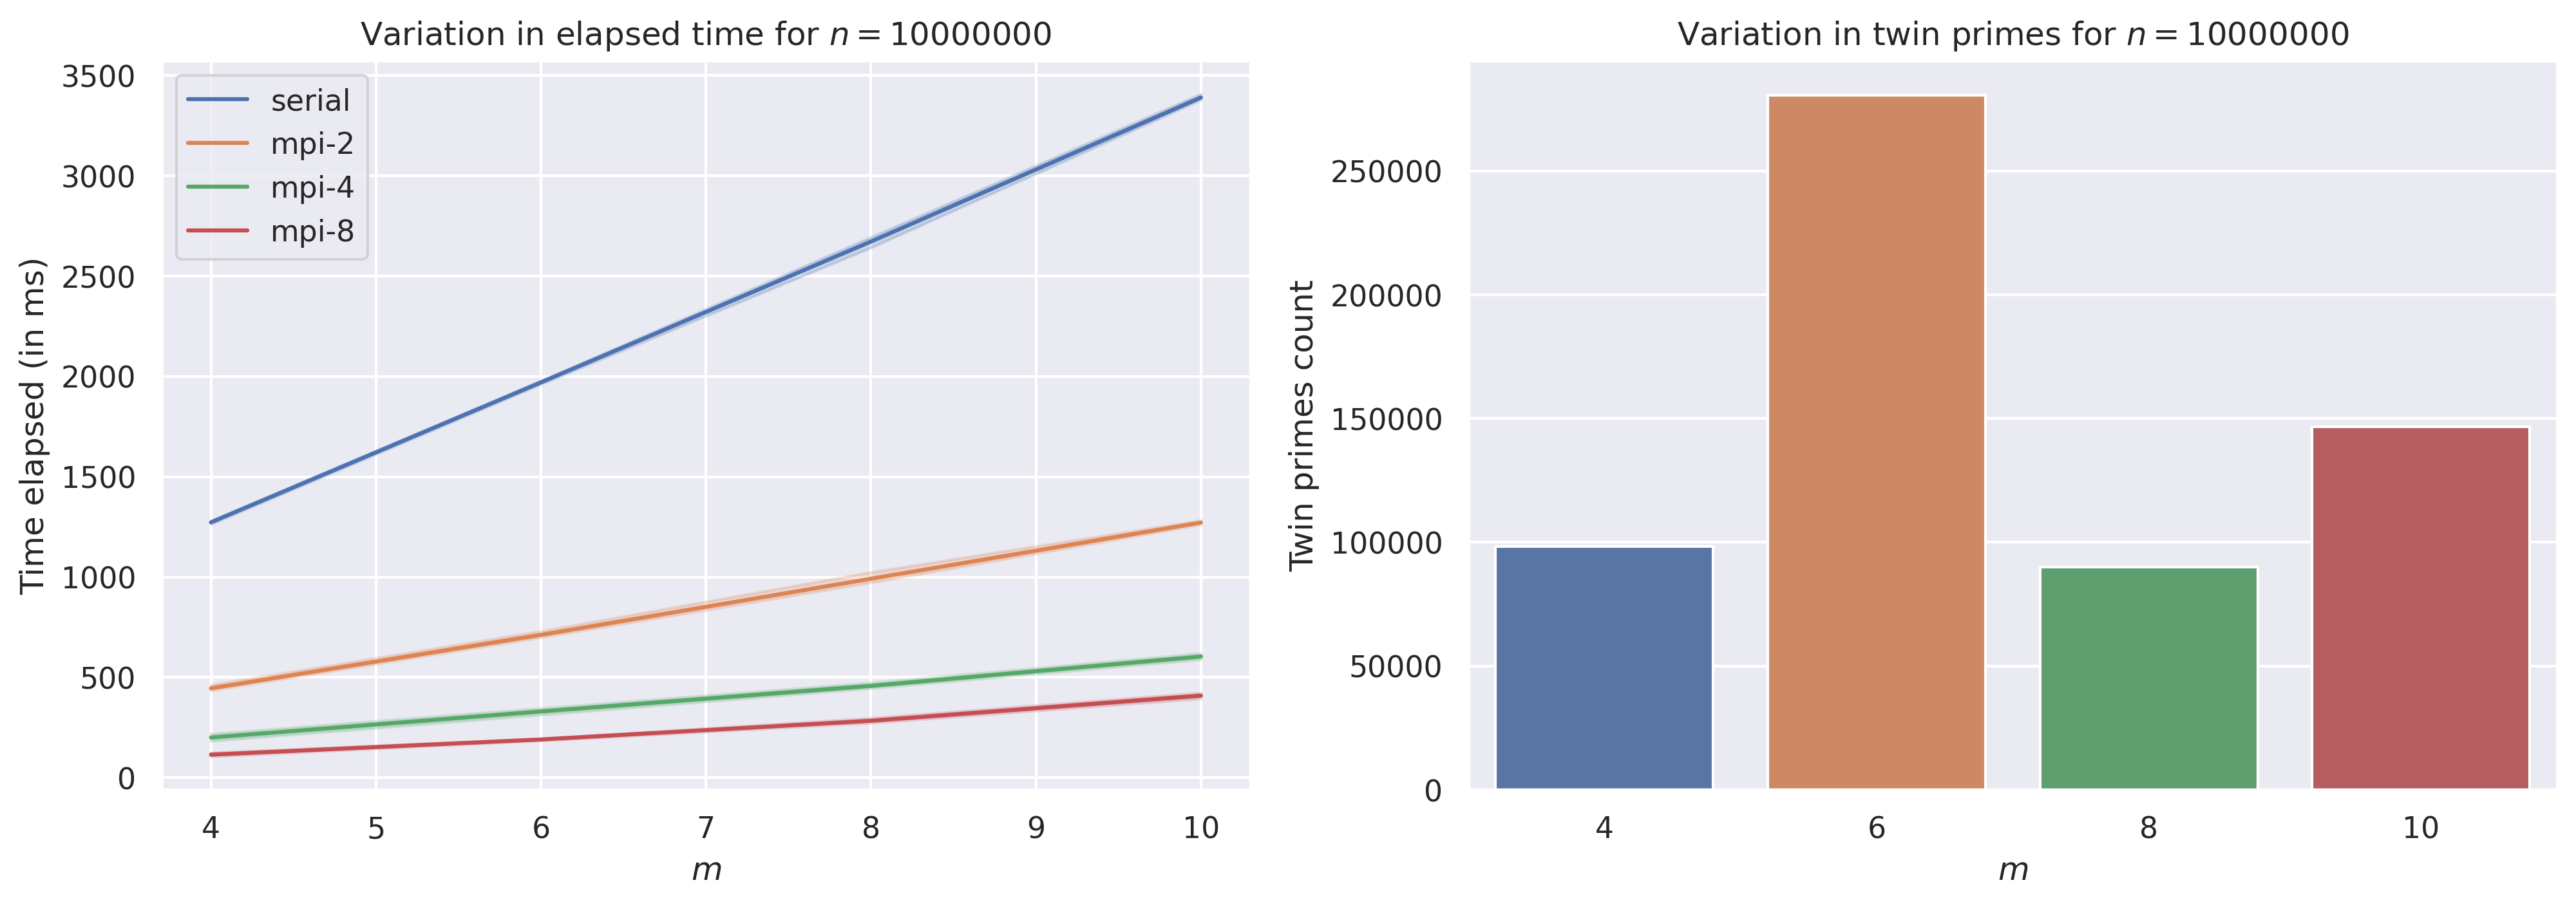

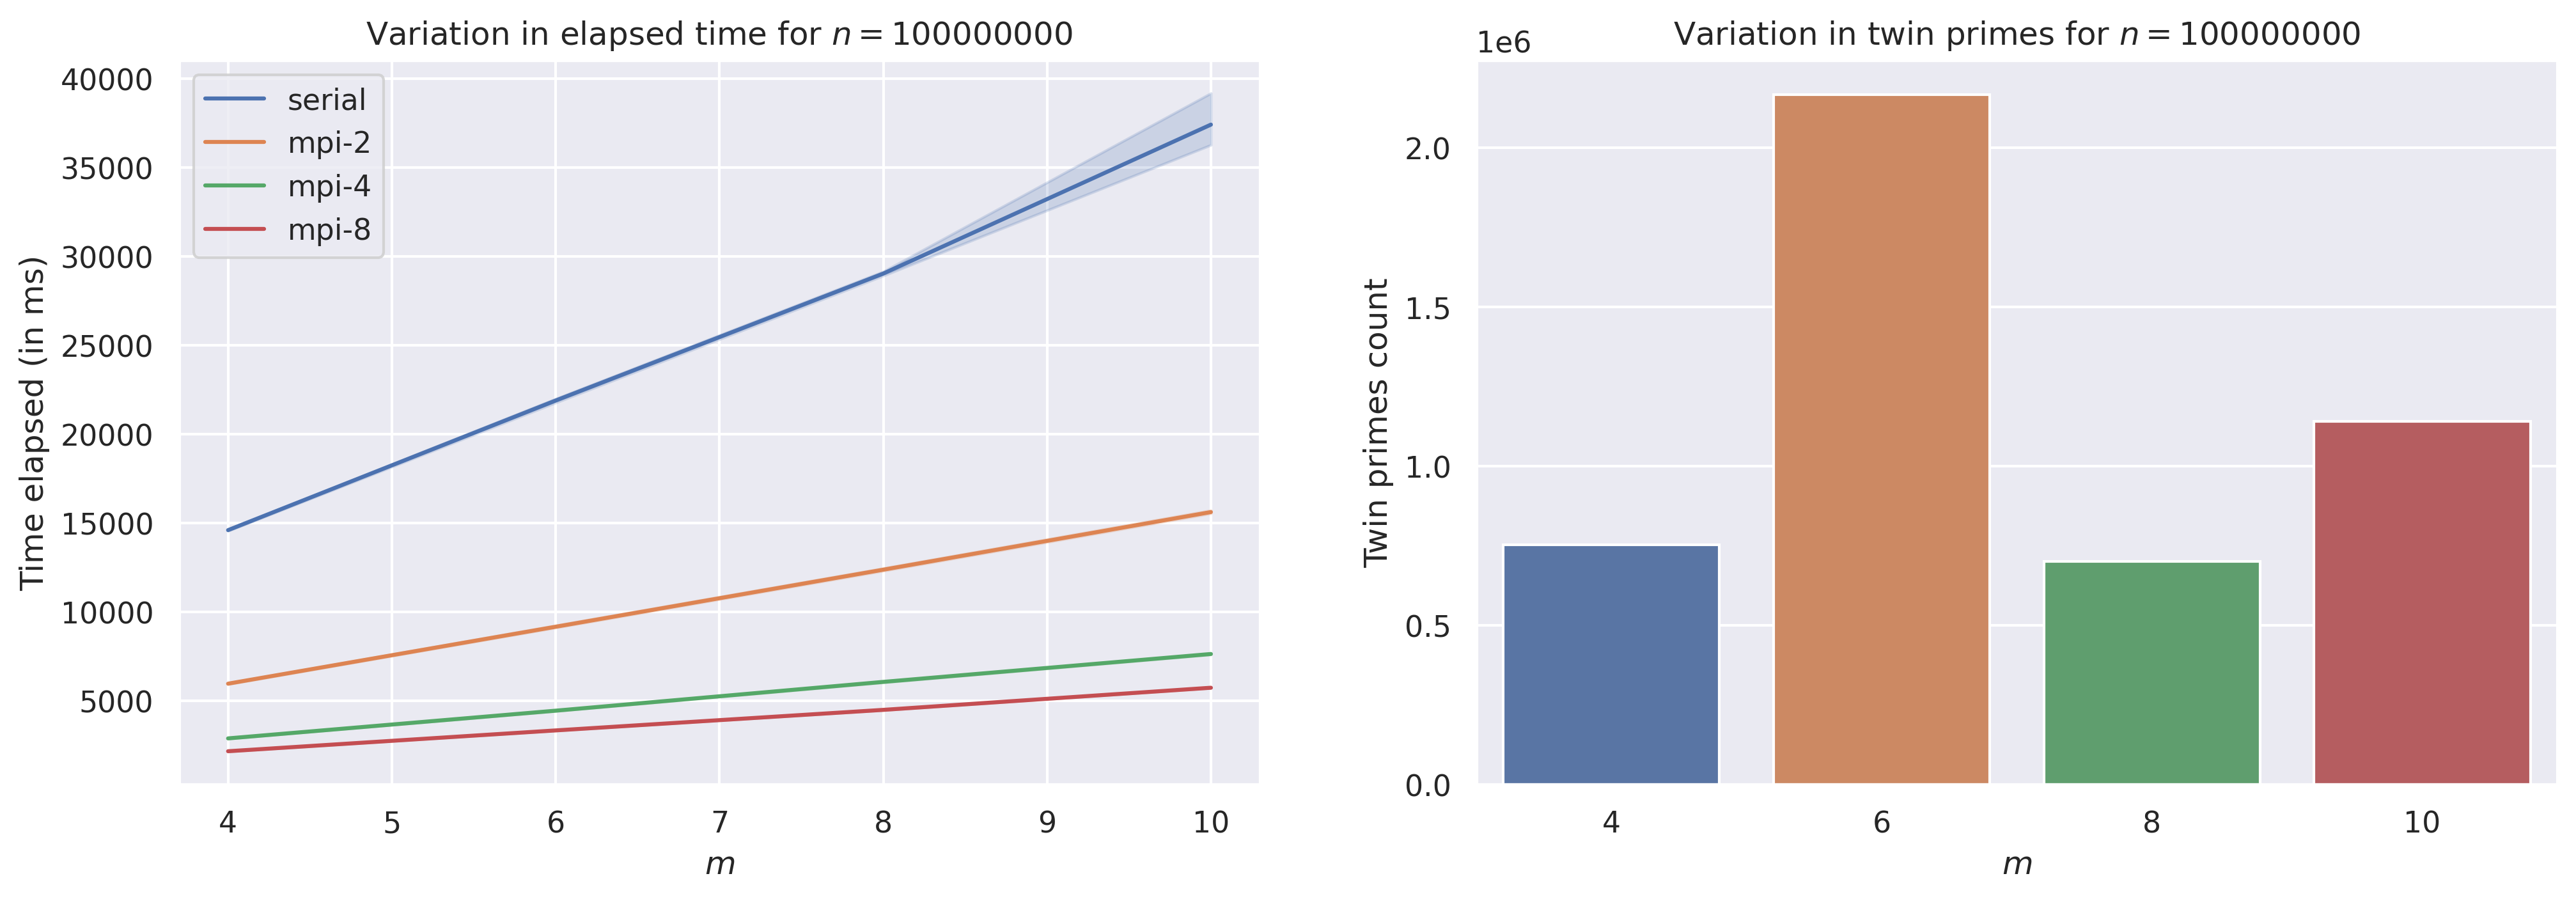

In [17]:
# Plot results 

def plot_time(k):
    """Plots the variation in elapsed time wrt. `m` for different run-time
    environments
    :param m: the value of `k` in `mk - 1` and `mk + 1`
    """
    fig, ax = plt.subplots(1, 2)

    sns.lineplot(data=data[k], x='m', y='time', hue='environment', ax=ax[0])
    ax[0].set_title(f'Variation in elapsed time for $n = {k}$')
    ax[0].set_xlabel('$m$')
    ax[0].set_ylabel('Time elapsed (in ms)')

    sns.barplot(data=data[k], x='m', y='primes', ax=ax[1])
    ax[1].set_title(f'Variation in twin primes for $n = {k}$')
    ax[1].set_xlabel('$m$')
    ax[1].set_ylabel('Twin primes count')

    fig.savefig(f'./plots/n_{k}.png', dpi=300)

for k in K:
    plot_time(k)

In [18]:
# Remove executable and object files

!make clean

rm -f serial serial.o parallel parallel.o
